In [26]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns


Notebooks de referencia: (para borrar antes de entrega)

https://www.kaggle.com/code/clemwo/bitcoin-transactions-graph-neural-networks

https://www.kaggle.com/code/nidropakshin/ellptic-data-gat-tagnn

https://www.kaggle.com/code/karthikapv/licit-illicit-logistic-regression



### Descripción del dataset

- first column (with name 0) is the transaction id;
- column 1 represents timesteps for each node. These timestamps have an interval of ~2 weeks. Each timestamp contains connected component of transactions, which appeared on the blockchain within less than three hours between each other;
- next 93 features show information about the transaction: number of inputs/outputs, transaction fee, output volume and aggregated figures such as average BTC received (spent) by the inputs/outputs and average number of incoming (outgoing) transactions associated with the inputs/outputs;
- the remaining 72 features are aggregated features, obtained using transaction information one-hop backward/forward from the center node - giving the maximum, minimum, standard deviation and correlation coefficients of the neighbour transactions for the same information data (number of inputs/outputs, transaction fee, etc.).


In [ ]:
# Cargar los archivos
features = pd.read_csv("../data/kaggle/elliptic_txs_features.csv", header=None)
edges = pd.read_csv("../data/kaggle/elliptic_txs_edgelist.csv")
classes = pd.read_csv("../data/kaggle/elliptic_txs_classes.csv")

# Renombrar columnas para claridad
features = features.rename(columns={0: "txId", 1: "time_step"})
edges = edges.rename(columns={"txId1": "source", "txId2": "target"})
classes = classes.rename(columns={"txId": "txId", "class": "label"})



Nodos: 203769, Aristas: 234355


# renaming columns
df_features.columns = ['id', 'time step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]


In [ ]:
print(f"""Shapes
{4*' '}Features : {features.shape[0]:8,} (rows)  {features.shape[1]:4,} (cols)
{4*' '}Classes  : {classes.shape[0]:8,} (rows)  {classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {edges.shape[0]:8,} (rows)  {edges.shape[1]:4,} (cols)
""")



Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



In [13]:
features.head()

,txId,time_step,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [10]:
classes.head()

,txId,label
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [11]:
edges.head()

,source,target
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


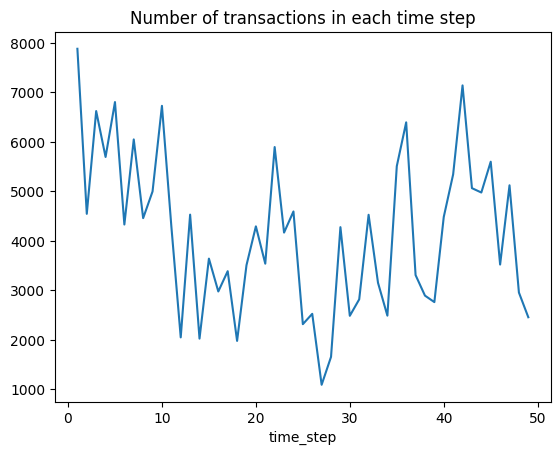

In [28]:
features['time_step'].value_counts().sort_index().plot();
plt.title('Number of transactions in each time step');



In [19]:
# merge with classes
features = pd.merge(features, classes, left_on='txId', right_on='txId', how='left')

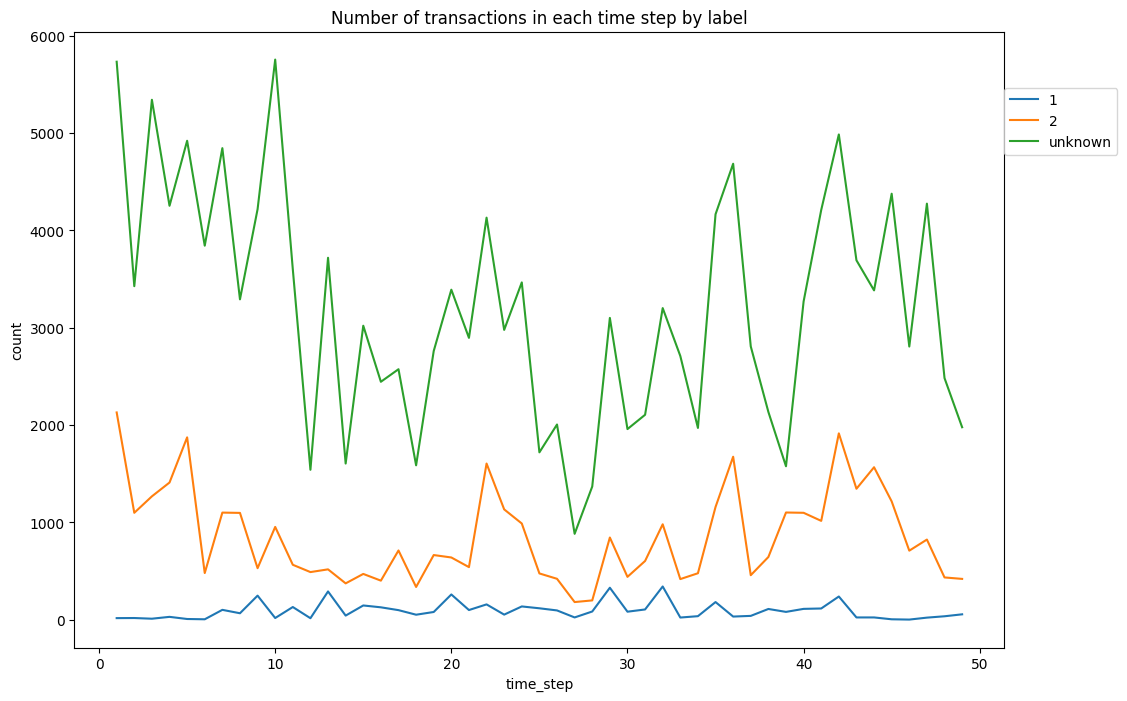

In [27]:
plt.figure(figsize=(12, 8))
grouped = features.groupby(['time_step', 'label'])['txId'].count().reset_index().rename(columns={'txId': 'count'})
sns.lineplot(x='time_step', y='count', hue='label', data=grouped);
plt.legend(loc=(1.0, 0.8));
plt.title('Number of transactions in each time step by label');

## Entrenamiento de Modelos

### Regresión logística

- Separar datos en train / test
- chequear si hay datos faltantes
- chequear si hay que escalar los datos

referencia: https://github.com/L-Ameneiro/IntroAprendizajeAutomatico/blob/master/Lab_2_g32.ipynb

### Decision tree